In [1]:
import numpy as np

In [2]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

In [3]:
root = '../../'

X_train = np.load( root + "Features/train_features_vgg16_cifar10.npy" )
y_train = np.load( root + "Features/train_labels_vgg16_cifar10.npy" )

X_test = np.load( root + "Features/test_features_vgg16_cifar10.npy" )
y_test = np.load( root + "Features/test_labels_vgg16_cifar10.npy" )

In [4]:
X_train.shape

(45000, 4096)

----

In [5]:
bits = 32

margin = int(bits / 10)
sample_size = len(X_train)
batchSize = 40

In [6]:
model = nn.Sequential(  nn.Linear(4096,256),
                        nn.ReLU(),
                        nn.Linear(256, bits),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [7]:
toTensor = transforms.ToTensor()


xSub = X_train[:sample_size]
ySub = y_train[:sample_size]

xTensor = toTensor(xSub)
xTensor.shape

torch.Size([1, 45000, 4096])

In [8]:
negative_i_dict = {}

for label in set(ySub):
    negative_i_dict[label] = [i for i in range(len(ySub)) if ySub[i] != label ]

------

In [9]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [10]:
xTensor.shape

torch.Size([1, 45000, 4096])

In [11]:
xTensor[0].shape

torch.Size([45000, 4096])

In [19]:
loss_list = []
for i in tqdm( range(5000) ):

    batch_i = random.sample(range(sample_size), batchSize)

    xBatch = torch.stack( [xTensor[0][j] for j in batch_i] )
    yBatch = [ySub[j] for j in batch_i]

    results = model(xBatch)
    results_np = results.detach().numpy()


    dMatrix = distance_matrix(results_np, results_np, p=1)

    APN_list = []

    for label in set(yBatch):
        pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

        for anchor_i in pos_i_list:
            pos_i = [j for j in pos_i_list if j != anchor_i]

            APN_list += getAPN(anchor_i, pos_i, dMatrix)

    if len(APN_list) > 0:
        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        loss_list.append( float(loss) )

    if (i % 200) == 0: 
        #print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
        
        if len(loss_list) != 0: print(i, sum(loss_list) / len(loss_list) )
        else: print(i, "Done")
        loss_list = []


  0%|          | 12/5000 [00:00<00:43, 114.69it/s]

0 1.6428654193878174


  4%|▍         | 221/5000 [00:01<00:38, 122.91it/s]

200 1.9132931411266327


  8%|▊         | 420/5000 [00:03<00:36, 124.14it/s]

400 1.9311445456743241


 12%|█▏        | 617/5000 [00:04<00:34, 128.46it/s]

600 1.9027743780612945


 16%|█▋        | 813/5000 [00:06<00:33, 124.18it/s]

800 1.902805294394493


 21%|██        | 1027/5000 [00:08<00:31, 127.82it/s]

1000 1.8913949626684188


 25%|██▍       | 1226/5000 [00:09<00:29, 128.00it/s]

1200 1.9089583379030228


 28%|██▊       | 1416/5000 [00:11<00:28, 127.74it/s]

1400 1.8930541634559632


 32%|███▏      | 1613/5000 [00:12<00:27, 122.95it/s]

1600 1.8922810316085816


 36%|███▌      | 1811/5000 [00:14<00:24, 129.04it/s]

1800 1.8945063418149948


 41%|████      | 2026/5000 [00:16<00:23, 126.91it/s]

2000 1.9188599324226379


 44%|████▍     | 2225/5000 [00:17<00:21, 129.49it/s]

2200 1.8894227015972138


 48%|████▊     | 2422/5000 [00:19<00:20, 127.31it/s]

2400 1.8985943841934203


 52%|█████▏    | 2623/5000 [00:20<00:18, 128.03it/s]

2600 1.8979389655590058


 56%|█████▋    | 2818/5000 [00:22<00:17, 128.02it/s]

2800 1.8955716460943222


 60%|██████    | 3020/5000 [00:23<00:15, 129.95it/s]

3000 1.8801683223247527


 64%|██████▍   | 3225/5000 [00:25<00:13, 127.76it/s]

3200 1.8835836535692214


 68%|██████▊   | 3412/5000 [00:26<00:12, 127.66it/s]

3400 1.8882462233304977


 72%|███████▏  | 3620/5000 [00:28<00:10, 130.51it/s]

3600 1.892943602204323


 77%|███████▋  | 3826/5000 [00:30<00:08, 131.72it/s]

3800 1.87935629427433


 80%|████████  | 4023/5000 [00:31<00:07, 132.92it/s]

4000 1.8960946643352508


 84%|████████▍ | 4221/5000 [00:33<00:05, 130.90it/s]

4200 1.8664187449216842


 88%|████████▊ | 4416/5000 [00:34<00:04, 128.17it/s]

4400 1.8925708949565887


 92%|█████████▏| 4623/5000 [00:36<00:02, 130.29it/s]

4600 1.8870142364501954


 96%|█████████▋| 4820/5000 [00:37<00:01, 132.04it/s]

4800 1.864415613412857


100%|██████████| 5000/5000 [00:38<00:00, 128.23it/s]


----

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

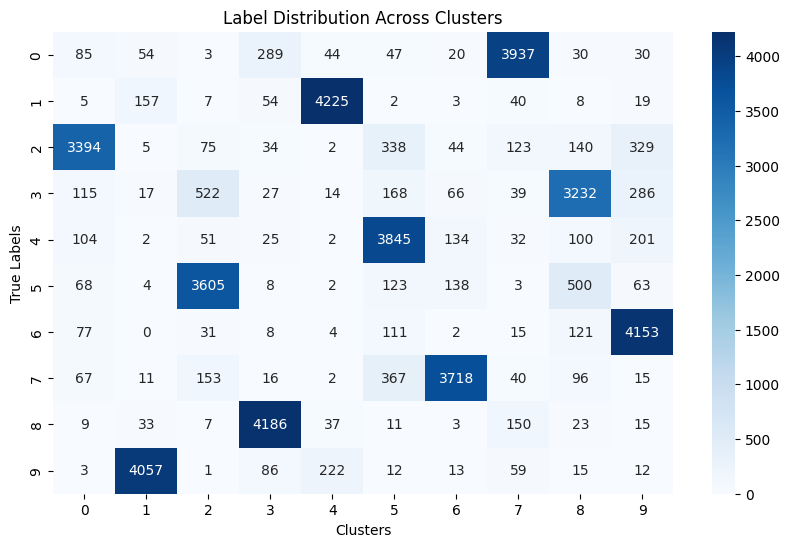

In [22]:
easyHeatmap(model(xTensor).detach().numpy()[0], ySub)

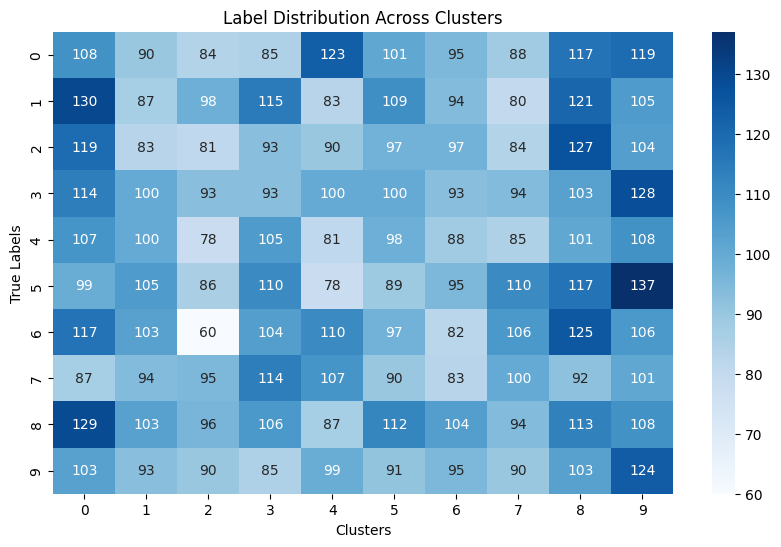

In [23]:
X_test_tensor = toTensor(X_test)
easyHeatmap(model(X_test_tensor).detach().numpy()[0], ySub)

In [24]:
def mean_average_precision(test_hashes, labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = labels[i]
        distances = np.abs(test_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.drop(index=i)
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [25]:
res = (model(X_test_tensor).detach().numpy()[0] > 0.5).astype(int)
mean_average_precision( res , y_test)

100%|██████████| 10000/10000 [00:43<00:00, 227.98it/s]


0.7424494350525948